In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import unittest

from skimage.metrics import peak_signal_noise_ratio

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 12})
torch.random.manual_seed(1904)
test = unittest.TestCase()

In [2]:
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(dev)
if dev is 'cuda':
  dtype = torch.cuda.FloatTensor
else:
  dtype = torch.FloatTensor
print(f'Using device {device}')

Using device cuda


In [3]:
from models import *
from models.unet import *

input_depth = 3
output_depth = 3

# Change IMAGE to jet for jet image or snail for snail image
IMAGE = 'snail'

if IMAGE == 'snail':
    net = UNet(3, 3, [8, 16, 32, 64, 128], [8, 16, 32, 64, 128], [0, 0, 0, 4, 4],
              [3, 3, 3, 3, 3], [3, 3, 3, 3, 3], [None, None, None, 1, 1]).type(dtype)
elif IMAGE == 'jet':
    net = UNet(3, 3, [128]*5, [128]*5, [4]*5,
              [3]*5, [3]*5, [1]*5).type(dtype)
else:
    assert False

net = net.to(device)
print(net)

UNet(
  (downs): ModuleList(
    (0): DownsampleBlock(
      (conv1): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2))
        (norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (conv2): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
        (norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): DownsampleBlock(
      (conv1): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
        (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (conv2): ConvBlock(
        (pad): 

In [4]:
s = sum([np.prod(list(p.size())) for p in net.parameters()])
print(f'Number of params: {s}')

# Loss 
mse = torch.nn.MSELoss()

Number of params: 572827


# Regular Training (no input optimization or adversarial training)

In [5]:
from utils import *
from input_gen import *

reg_noise_std = 1./30.

fname_snail = 'data/denoising/snail.jpg'
fname_jet = 'data/denoising/F16_GT.png'
fname = fname_snail if IMAGE == 'snail' else fname_jet

use_noise = False if IMAGE == 'snail' else True

img_pil = crop_image(get_image(fname, -1)[0])
img_np = pil_to_np(img_pil)
img_tr = torch.from_numpy(img_np)
target_img = img_tr

if use_noise:
    target_noisy_img, _ = add_noise_to_tensor(target_img, 'normal', std=reg_noise_std)
else:
    target_noisy_img = target_img

target_noisy_img = target_noisy_img.unsqueeze(dim=0).to(device)

net_input = get_noise(*img_tr.shape, method='noise').unsqueeze(dim=0).detach().to(device)

noise = net_input.detach().clone()

C:\Users\User\Miniconda3\envs\cs236781-hw\lib\site-packages\torch\nn\functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


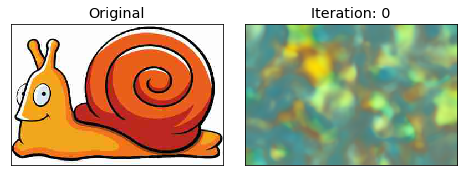

Iteration  50   Loss = 0.061896   PSNR noisy = 12.083380   PSNR gt = 12.083380        
Iteration  100   Loss = 0.043173   PSNR noisy = 13.647916   PSNR gt = 13.647916              


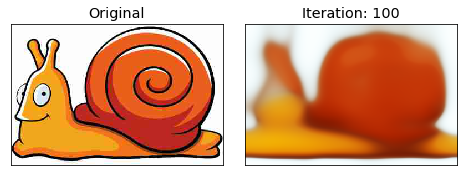

Iteration  150   Loss = 0.035046   PSNR noisy = 14.553660   PSNR gt = 14.553660              
Iteration  200   Loss = 0.031335   PSNR noisy = 15.039717   PSNR gt = 15.039717               


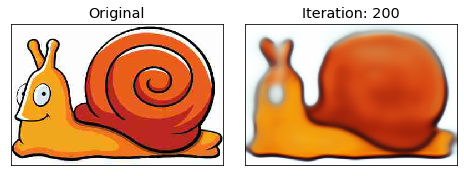

Iteration  250   Loss = 0.028189   PSNR noisy = 15.499198   PSNR gt = 15.499198             
Iteration  300   Loss = 0.020900   PSNR noisy = 16.798484   PSNR gt = 16.798484          


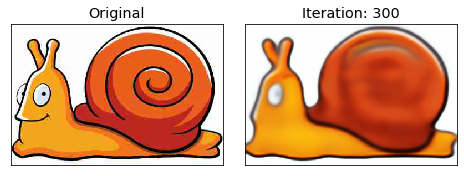

Iteration  350   Loss = 0.017749   PSNR noisy = 17.508326   PSNR gt = 17.508326                
Iteration  400   Loss = 0.014857   PSNR noisy = 18.280547   PSNR gt = 18.280547                      


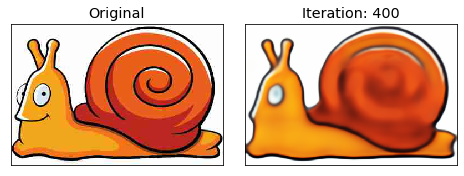

Iteration  450   Loss = 0.012294   PSNR noisy = 19.102910   PSNR gt = 19.102910                    
Iteration  500   Loss = 0.010883   PSNR noisy = 19.632549   PSNR gt = 19.632549                         


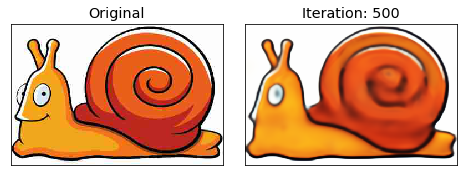

Iteration  550   Loss = 0.009436   PSNR noisy = 20.252055   PSNR gt = 20.252055                      
Iteration  600   Loss = 0.008929   PSNR noisy = 20.492167   PSNR gt = 20.492167                 


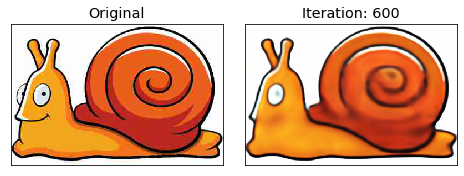

Iteration  650   Loss = 0.007371   PSNR noisy = 21.324600   PSNR gt = 21.324600                
Iteration  700   Loss = 0.007365   PSNR noisy = 21.328508   PSNR gt = 21.328508                


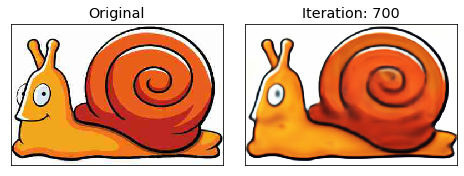

Iteration  750   Loss = 0.007229   PSNR noisy = 21.409315   PSNR gt = 21.409315                    
Iteration  800   Loss = 0.006751   PSNR noisy = 21.705998   PSNR gt = 21.705998              


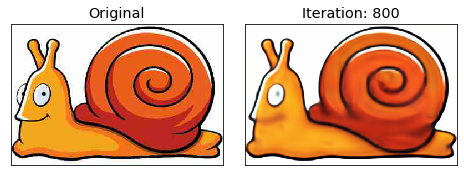

Iteration  850   Loss = 0.007035   PSNR noisy = 21.527336   PSNR gt = 21.527336               
Iteration  900   Loss = 0.005568   PSNR noisy = 22.543281   PSNR gt = 22.543281            


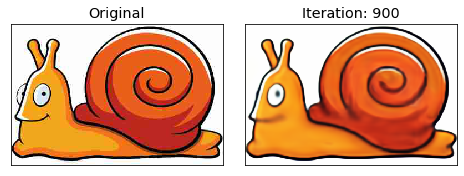

Iteration  950   Loss = 0.005658   PSNR noisy = 22.473014   PSNR gt = 22.473014              
Iteration  1000   Loss = 0.005483   PSNR noisy = 22.609913   PSNR gt = 22.609913            


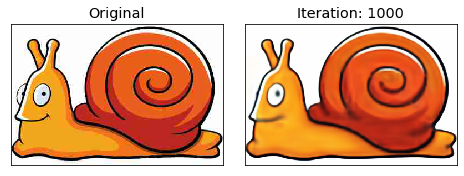

Iteration  1050   Loss = 0.004953   PSNR noisy = 23.051581   PSNR gt = 23.051581                         
Iteration  1100   Loss = 0.005190   PSNR noisy = 22.848427   PSNR gt = 22.848427                   


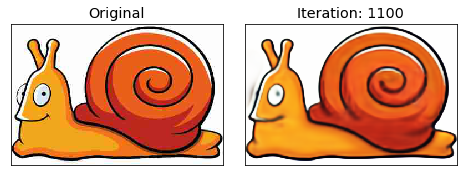

Iteration  1150   Loss = 0.004390   PSNR noisy = 23.575457   PSNR gt = 23.575457                  
Iteration  1200   Loss = 0.004510   PSNR noisy = 23.458036   PSNR gt = 23.458036                  


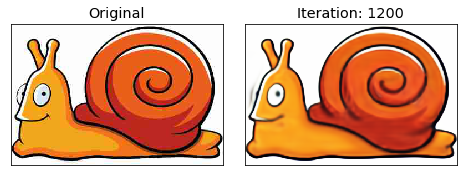

Iteration  1250   Loss = 0.004601   PSNR noisy = 23.371560   PSNR gt = 23.371560            
Iteration  1300   Loss = 0.004244   PSNR noisy = 23.722185   PSNR gt = 23.722185          


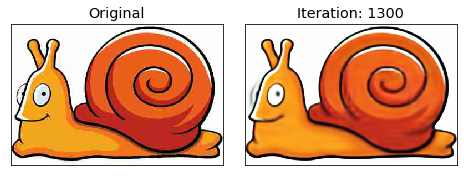

Iteration  1350   Loss = 0.004125   PSNR noisy = 23.845599   PSNR gt = 23.845599            
Iteration  1400   Loss = 0.004100   PSNR noisy = 23.872655   PSNR gt = 23.872655      


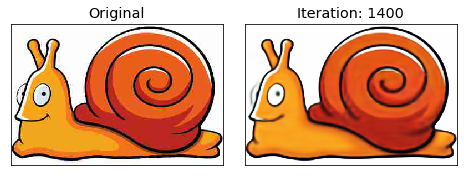

Iteration  1450   Loss = 0.003866   PSNR noisy = 24.127498   PSNR gt = 24.127498      
Iteration  1500   Loss = 0.003806   PSNR noisy = 24.194862   PSNR gt = 24.194862    


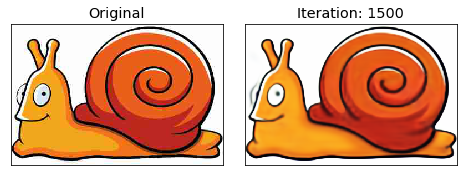

Iteration  1550   Loss = 0.003825   PSNR noisy = 24.174069   PSNR gt = 24.174069    
Iteration  1600   Loss = 0.004042   PSNR noisy = 23.934116   PSNR gt = 23.934116        


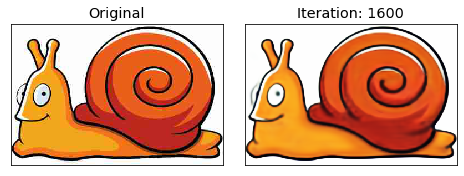

Iteration  1650   Loss = 0.003389   PSNR noisy = 24.699709   PSNR gt = 24.699709  
Iteration  1700   Loss = 0.003554   PSNR noisy = 24.492374   PSNR gt = 24.492374     


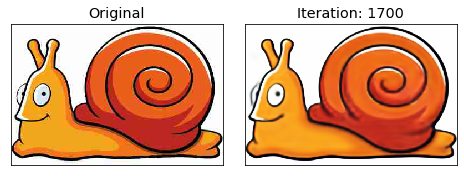

Iteration  1750   Loss = 0.003521   PSNR noisy = 24.533347   PSNR gt = 24.533347      
Iteration  1800   Loss = 0.003377   PSNR noisy = 24.714300   PSNR gt = 24.714300     


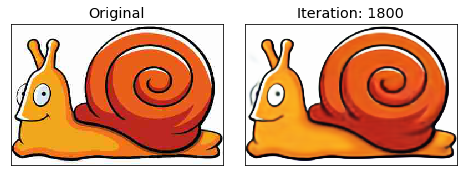

Iteration  1850   Loss = 0.003373   PSNR noisy = 24.720065   PSNR gt = 24.720065   
Iteration  1900   Loss = 0.003158   PSNR noisy = 25.006470   PSNR gt = 25.006470         


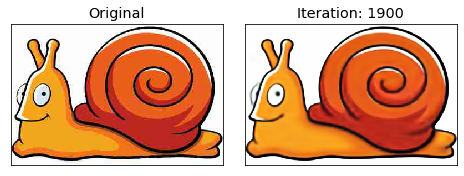

Iteration  1950   Loss = 0.003357   PSNR noisy = 24.740206   PSNR gt = 24.740206       
Iteration  2000   Loss = 0.003105   PSNR noisy = 25.079213   PSNR gt = 25.079213   


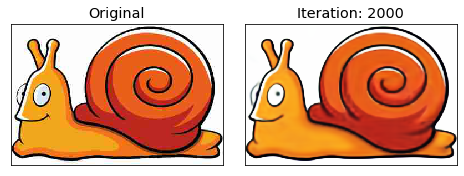

Iteration  2050   Loss = 0.003379   PSNR noisy = 24.711892   PSNR gt = 24.711892      
Iteration  2100   Loss = 0.003193   PSNR noisy = 24.957881   PSNR gt = 24.957881       


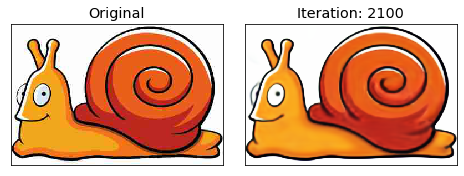

Iteration  2150   Loss = 0.003270   PSNR noisy = 24.854137   PSNR gt = 24.854137           
Iteration  2200   Loss = 0.003295   PSNR noisy = 24.821228   PSNR gt = 24.821228      


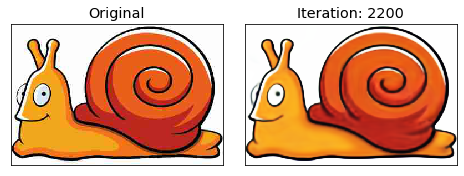

Iteration  2250   Loss = 0.002962   PSNR noisy = 25.283789   PSNR gt = 25.283789    
Iteration  2300   Loss = 0.003279   PSNR noisy = 24.842241   PSNR gt = 24.842241  


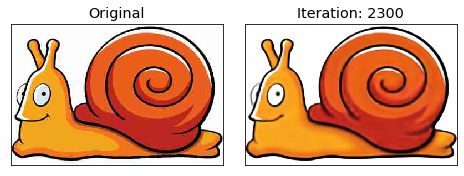

Iteration  2350   Loss = 0.003071   PSNR noisy = 25.126732   PSNR gt = 25.126732            
Done training final Loss = 0.0030622195918112993   PSNR = 25.139636302521872   PSNR gt = 25.139636302521872


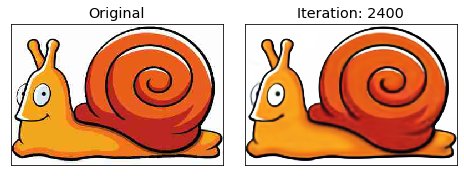

In [6]:
# Training loop, can change hyperparameters mid way
parameters = [x for x in net.parameters()]
LR = 0.01
num_iter = 2400
show_every = 50
optimizer = torch.optim.Adam(parameters, lr=LR)

psnr_noisy_res = []
psnr_gt_res = []
losses_res = []

for i in range(num_iter):
    optimizer.zero_grad()
    
    if reg_noise_std > 0:
        net_input_mod = net_input + (noise.normal_() * reg_noise_std)
    else:
        net_input_mod = net_input.clone()
        
    out = net(net_input_mod)
    loss = mse(out, target_noisy_img)
    loss.backward()
    
    psnr_noisy = peak_signal_noise_ratio(target_noisy_img.detach().cpu().numpy()[0],
                                         out.detach().cpu().numpy()[0])
    psnr_gt = peak_signal_noise_ratio(img_np, out.detach().cpu().numpy()[0]) 
    
    psnr_noisy_res.append(psnr_noisy)
    psnr_gt_res.append(psnr_gt)
    losses_res.append(loss.item())
    # psrn_gt_sm = peak_signal_noise_ratio(img_np, out_avg.detach().cpu().numpy()[0])
    
    optimizer.step()
    
    print('Iteration  %d   Loss = %06f   PSNR noisy = %06f   PSNR gt = %06f' %
          (i, loss.item(), psnr_noisy, psnr_gt), '\r', end='')
    if i % show_every == 0 and i:
        print('Iteration  %d   Loss = %06f   PSNR noisy = %06f   PSNR gt = %06f' %
          (i, loss.item(), psnr_noisy, psnr_gt))
    if i % (show_every*2) == 0:
        fig, axes = tensors_as_images([target_noisy_img[0], out[0].detach()], 
                                        titles=['Original', f'Iteration: {i}'])
        
print(f'Done training final Loss = {loss.item()}   PSNR = {psnr_noisy}   PSNR gt = {psnr_gt}')
fig, axes = tensors_as_images([target_noisy_img[0], out[0].detach()], 
                                        titles=['Original', f'Iteration: {num_iter}'])


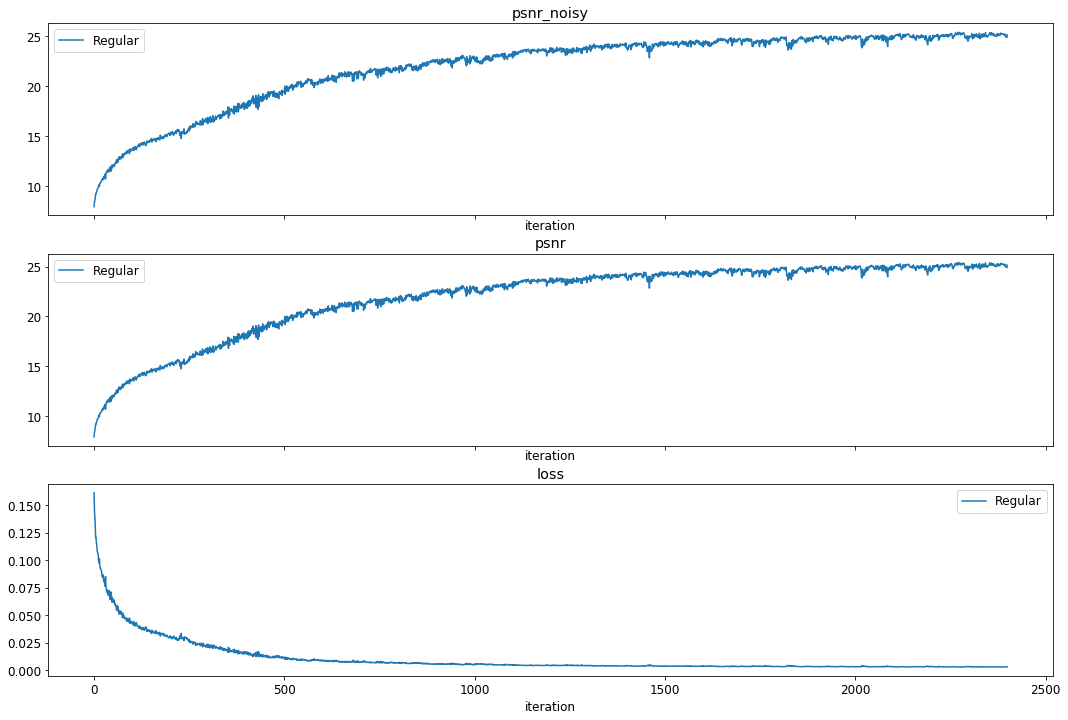

In [7]:
def plot_experiment_results(results, exp_name, fig=None):
    if fig is None:
        fig, _ = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(18,12))
    for i, plot_type in enumerate(('psnr_noisy', 'psnr', 'loss')):
        ax = fig.axes[i]
        if plot_type not in results:
            continue
        exp_res = results[plot_type]    
        ax.plot(list(range(len(exp_res))), exp_res, label=exp_name)
        ax.set_title(plot_type)
        ax.set_xlabel('iteration')
        ax.legend()
    return fig
    
experiments_results_fig = plot_experiment_results({'psnr': psnr_gt_res, 'psnr_noisy': psnr_noisy_res, 'loss': losses_res}, 'Regular')

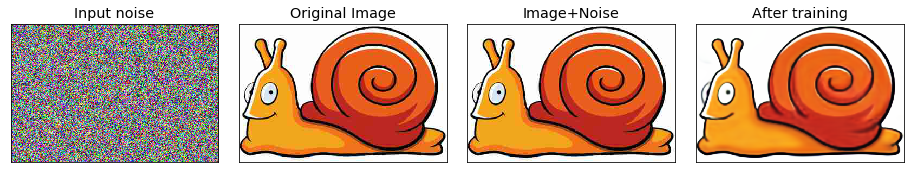

In [8]:
# Showing result of the training using original noise
with torch.no_grad():
    original_noise = net_input
    output = net(original_noise).detach()
    output = output.squeeze(dim=0)
    fig, axes = tensors_as_images([original_noise.squeeze(dim=0), img_tr, target_noisy_img.squeeze(dim=0), output], 
                                        titles=['Input noise', 'Original Image', 'Image+Noise', 'After training'],
                                        figsize=(16,16))
    output_pil = np_to_pil(output.detach().cpu().numpy())
    output_pil.save(f'results/denoising/{IMAGE}.png')
    regular_trained_output = output

# Regular Training with input optimization

In [9]:
if IMAGE == 'snail':
    net = UNet(3, 3, [8, 16, 32, 64, 128], [8, 16, 32, 64, 128], [0, 0, 0, 4, 4],
              [3, 3, 3, 3, 3], [3, 3, 3, 3, 3], [None, None, None, 1, 1]).type(dtype)
elif IMAGE == 'jet':
    net = UNet(3, 3, [128]*5, [128]*5, [4]*5,
              [3]*5, [3]*5, [1]*5).type(dtype)
else:
    assert False
net.to(device)

new_input = net_input.clone().detach()

TypeError: __init__() got an unexpected keyword argument 'weight_std'

In [ ]:
# Training loop, can change hyperparameters mid way
parameters = [x for x in net.parameters()]
LR = 0.01
num_iter = 2400
show_every = 50
optimizer = torch.optim.Adam(parameters, lr=LR)
input_optimizer = torch.optim.Adam([new_input.requires_grad_()], lr=LR)
in_opt_psnr_noisy_res = []
in_opt_psnr_gt_res = []
in_opt_losses_res = []
for i in range(num_iter):
    optimizer.zero_grad()
    input_optimizer.zero_grad()
    out = net(new_input)
    loss = mse(out, target_noisy_img)
    loss.backward()
    psnr_noisy = peak_signal_noise_ratio(target_noisy_img.detach().cpu().numpy()[0],
                                         out.detach().cpu().numpy()[0])
    psnr_gt = peak_signal_noise_ratio(img_np, out.detach().cpu().numpy()[0]) 
    # psrn_gt_sm = peak_signal_noise_ratio(img_np, out_avg.detach().cpu().numpy()[0])
    optimizer.step()
    input_optimizer.step()
    in_opt_psnr_noisy_res.append(psnr_noisy)
    in_opt_psnr_gt_res.append(psnr_gt)
    in_opt_losses_res.append(loss.item())
    print('Iteration  %d   Loss = %06f   PSNR noisy = %06f   PSNR gt = %06f' %
          (i, loss.item(), psnr_noisy, psnr_gt), '\r', end='')
    if i % show_every == 0 and i:
        print('Iteration  %d   Loss = %06f   PSNR noisy = %06f   PSNR gt = %06f' %
          (i, loss.item(), psnr_noisy, psnr_gt))
    if i % (show_every*2) == 0:
        fig, axes = tensors_as_images([target_noisy_img[0], out[0].detach()], 
                                        titles=['Original', f'Iteration: {i}'])
print(f'Done training final Loss = {loss.item()}   PSNR = {psnr_noisy}   PSNR gt = {psnr_gt}')
fig, axes = tensors_as_images([target_noisy_img[0], out[0].detach()], 
                                        titles=['Original', f'Iteration: {num_iter}'])

In [ ]:
# Showing result of the training using original noise
with torch.no_grad():
    optimized_noise = new_input
    output = net(optimized_noise).detach()
    output = output.squeeze(dim=0)
    fig, axes = tensors_as_images([optimized_noise.squeeze(dim=0).detach(), img_tr, target_noisy_img.squeeze(dim=0), output], 
                                        titles=['Optim input', 'Original Image', 'Image+Noise', 'After training'],
                                        figsize=(16,16))
    output_pil = np_to_pil(output.detach().cpu().numpy())
    output_pil.save(f'results/denoising/{IMAGE}_input_optimization.png')
    input_optimized_trained_output = output

In [ ]:
experiments_results_fig = plot_experiment_results({'psnr': psnr_gt_res, 'psnr_noisy': psnr_noisy_res, 'loss': losses_res}, 'Regular')
experiments_results_fig = plot_experiment_results({'psnr': in_opt_psnr_gt_res, 'psnr_noisy': in_opt_psnr_noisy_res, 'loss': in_opt_losses_res}, 'Input Optim', fig=experiments_results_fig);

# Adversarial Training

In [ ]:
from models.adverserialModel import *

# Models
if IMAGE == 'snail':
    gen = UNet(3, 3, [8, 16, 32, 64, 128], [8, 16, 32, 64, 128], [0, 0, 0, 4, 4],
              [3, 3, 3, 3, 3], [3, 3, 3, 3, 3], [None, None, None, 1, 1])
elif IMAGE == 'jet':
    gen = UNet(3, 3, [128]*5, [128]*5, [4]*5,
              [3]*5, [3]*5, [1]*5)
else:
    assert False
    
gen.to(device)
# gen = net 
dsc = Discriminator(img_tr.shape).to(device)

# Hyperparams
DSC_LR = 0.008
GEN_LR = 0.008
DATA_LABEL = 1
LABEL_NOISE = 0.2
num_iter = 3000
weight_decay = 0.005

# Optimizers
dsc_optimizer = torch.optim.Adam(dsc.parameters(), DSC_LR, weight_decay=weight_decay)
gen_optimizer = torch.optim.Adam(gen.parameters(), GEN_LR, weight_decay=weight_decay)

# Loss
def dsc_loss_fn(y_data, y_generated):
    return discriminator_loss_fn(y_data, y_generated, DATA_LABEL, LABEL_NOISE)

def gen_loss_fn(y_generated):
    return generator_loss_fn(y_generated, DATA_LABEL)

# Gen input
# net_input = get_noise(input_depth, *img_tr.shape[1:], method='noise').unsqueeze(dim=0).detach().to(device)
# noise = net_input.detach().clone()
# if reg_noise_std > 0:
#         net_input = net_input + (noise.normal_() * reg_noise_std)

In [ ]:
# Training loop
adv_psnr_noisy_res = []
adv_psnr_gt_res = []
for i in range(num_iter):
    dsc_loss, gen_loss, output = train_batch(dsc, gen, dsc_loss_fn, gen_loss_fn,
                                    dsc_optimizer, gen_optimizer,
                                    target_noisy_img, net_input)
    psnr_noisy = peak_signal_noise_ratio(target_noisy_img.detach().cpu().numpy()[0],
                                         output.detach().cpu().numpy()[0])
    psnr_gt = peak_signal_noise_ratio(img_np, output.detach().cpu().numpy()[0]) 
    adv_psnr_noisy_res.append(psnr_noisy)
    adv_psnr_gt_res.append(psnr_gt)
    print('Iteration  %d   Gen Loss = %06f   Dsc Loss = %06f   PSNR noisy = %06f   PSNR = %06f' % 
          (i, gen_loss, dsc_loss, psnr_noisy, psnr_gt), '\r', end='')
    if i % show_every == 0 and i:
        print('Iteration  %d   Gen Loss = %06f   Dsc Loss = %06f   PSNR noisy = %06f   PSNR = %06f' % 
              (i, gen_loss, dsc_loss, psnr_noisy, psnr_gt))
    if i % (show_every*2) == 0:
        fig, axes = tensors_as_images([img_tr, output[0].detach()], 
                                      titles=['Original', f'Iteration: {i}'], cmap='Greys')
    

In [ ]:
# Showing result of the training using original noise
with torch.no_grad():
    original_noise = net_input
    output = gen(original_noise).detach()
    output = output.squeeze(dim=0)
    fig, axes = tensors_as_images([img_tr, regular_trained_output, input_optimized_trained_output, output], 
                                        titles=['Original Image', 'Regular training', 'Input Optim', 'Adversarial training'],
                                        figsize=(16,16), cmap='Greys')
    output_pil = np_to_pil(output.detach().cpu().numpy())
    output_pil.save(f'results/denoising/{IMAGE}_adversarial.png')

In [ ]:
plot_experiment_results({'psnr': adv_psnr_gt_res, 'psnr_noisy': adv_psnr_noisy_res}, 'Adversarial', fig=experiments_results_fig)